In [0]:
import pystan
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

 # Exercise 1: Call center dataset  
Exponential likelihood with gamma prior

In [0]:
# Load the data set containing durations between calls arriving at the call center.
waiting_times_day = "/content/gdrive/My Drive/Colab Notebooks/call_center.csv"
waiting_times_day = np.loadtxt(waiting_times_day)

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)
    
hour_index = 13
waiting_times = waiting_times_per_hour[hour_index]

## Task: Fit an exponential distribution to the data for hour 13
Use the exponential distribution as your likelihood function. The exponential distribution has 1 parameter, namely the rate $\lambda$. Use a gamma distribution with parameters $\alpha=1$ and $\beta=0.25$ as your prior.
Compute the posterior gamma distribution over $\lambda$. 

In [0]:
# Defining the model

code_expon = '''

data {
    int<lower=1> n;
    real<lower=0> waiting_times[n];
    real<lower=0> alpha; // prior hyperparameter for the gamma distribution
    real<lower=0> beta; // prior hyperparameter for the gamma distirbution
}

parameters {
    real<lower=0> lambda; // parameter for the exponential distribution
}

model {
    lambda ~ gamma(alpha, beta); // gamma prior
    waiting_times ~ exponential(lambda); // exponential likelihood
}
'''

# Compiling the Stan model

model_expon = pystan.StanModel(model_code=code_expon)

In [9]:
# Fitting model to data

data_expon = {
    'waiting_times': waiting_times, 
    'n': len(waiting_times),
    'alpha': 1,
    'beta': 0.25}
results_expon = model_expon.sampling(data=data_expon)
print(results_expon)

Inference for Stan model: anon_model_7b8d304000b6c206e61626a1a5c373bb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.35  8.0e-3   0.32   5.75   6.13   6.34   6.57   7.01   1606    1.0
lp__   324.44    0.02   0.69 322.45 324.29 324.69 324.87 324.92   1675    1.0

Samples were drawn using NUTS at Fri Feb 21 14:27:19 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 98% confidence interval over λ: [5.63656498 7.13546833]


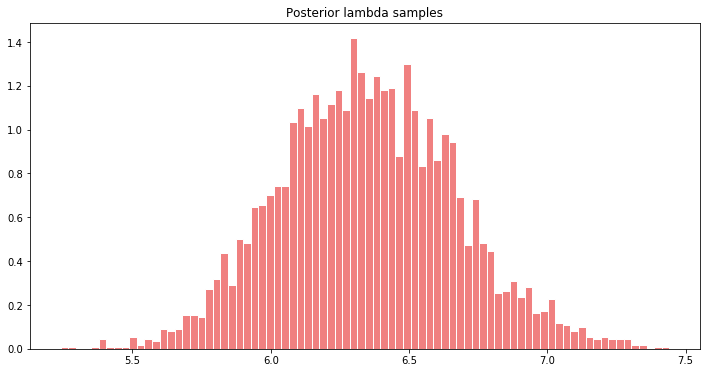

In [21]:
# Extracting samples

samples_expon = results_expon.extract()

# Calculating 98% confidence interval over lambda 
conf_int = np.percentile(samples_expon['lambda'], [1, 99])
print('Posterior 98% confidence interval over λ:', conf_int)

# Plotting histogram of posterior lambda samples
plt.figure(figsize=(12, 6))
plt.hist(samples_expon['lambda'], bins=80, density=True, color='lightcoral',ec='white')
plt.title('Posterior lambda samples')
plt.show()

# Exercise 2: Inferring mean and variance of normally distributed data
Normal likelihood with normal-inverse-gamma prior

In [13]:
data_array = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 
                 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 
                 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 
                 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 
                 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 
                 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 
                 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 
                 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 
                 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, 
                 -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 
                 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 
                 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 
                 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 
                 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 
                 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 
                 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 
                 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 
                 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 
                 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 
                 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 
                 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 
                 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 
                 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 
                 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 
                 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 
                 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 
                 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 
                 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 
                 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 
                 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 
                 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 
                 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 
                 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 
                 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 
                 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 
                 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 
                 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 
                 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 
                 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 
                 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(data_array))

200


## Task: Calculate posterior for a normal likelihood with normal-inverse-gamma prior
Use the normal distribution as your likelihood function. The normal distribution has 2 parameters, the mean $\mu$ and the variance $\sigma^2$. Use a normal-inverse-gamma distribution with parameters $\mu_0=0$, $\nu_0=0.054$, $\alpha_0=1.12$ and $\beta_0=0.4$ as prior.

Compute the posterior normal-inverse-gamma distribution over mean $\mu$ and variance $\sigma^2$.

In [0]:
# Defining the model

code_NIG = '''

data {
    int<lower=1> n;
    real data_array[n];
    real mu_0; // prior hyperparameter for the normal-inverse-gamma distribution
    real<lower=0> nu_0; // prior hyperparameter for the normal-inverse-gamma distribution
    real<lower=0> alpha_0; // prior hyperparameter for the normal-inverse-gamma distribution
    real<lower=0> beta_0; // prior hyperparameter for the normal-inverse-gamma distribution
}

parameters {
    real mu;
    real <lower=0> sigma2;
}

model {
    sigma2 ~ inv_gamma(alpha_0, beta_0); // sample sigma2 from an inverse-gamma distribution with hyperparameters alpha_0 and beta_0 
    mu ~ normal(mu_0, sqrt(sigma2/nu_0)); // sample mu from a normal distribution with hyperparameters mu_0 and sigma2/nu_0
    data_array ~ normal(mu, sqrt(sigma2)); // normal likelihood

}
'''

# Compiling the Stan model

model_NIG = pystan.StanModel(model_code=code_NIG)

In [14]:
# Fitting model to data

data_NIG = {
    'data_array': data_array, 
    'n': len(data_array),
    'mu_0': 0,
    'nu_0': 0.054,
    'alpha_0': 1.12,
    'beta_0': 0.4
}

results_NIG = model_NIG.sampling(data=data_NIG)
print(results_NIG)

Inference for Stan model: anon_model_7172d74fc28bb6f25a82f0e31c97aa40.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       3.07  2.4e-3   0.14   2.79   2.98   3.07   3.15   3.33   3101    1.0
sigma2   3.62  6.6e-3   0.37   2.96   3.37    3.6   3.85   4.39   3069    1.0
lp__   -233.2    0.03   1.04 -235.9 -233.6 -232.9 -232.5 -232.2   1642    1.0

Samples were drawn using NUTS at Fri Feb 21 14:43:09 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% confidence interval over 𝜇: [2.79385485 3.33184681]
Posterior 95% confidence interval over 𝜎^2: [2.96216135 4.3907979 ]


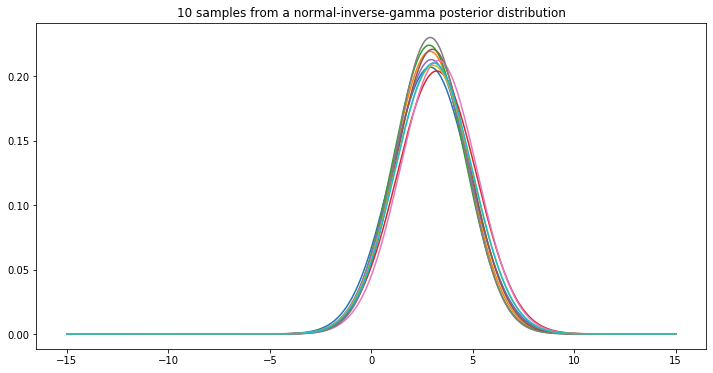

In [15]:
# Extracting samples

samples_NIG = results_NIG.extract()

# Calculating 95% posterior confidence intervals over mu and sigma2

conf_int_mu = np.percentile(samples_NIG['mu'], [2.5, 97.5])
print('Posterior 95% confidence interval over 𝜇:', conf_int_mu)
conf_int_sigma2 = np.percentile(samples_NIG['sigma2'], [2.5, 97.5])
print('Posterior 95% confidence interval over 𝜎^2:', conf_int_sigma2)

# Taking 10 samples from the posterior over mu and sigma2

num_samples = 10
sample_mu = np.random.choice(samples_NIG['mu'],num_samples)
sample_sigma2 = np.random.choice(samples_NIG['sigma2'],num_samples)

# Plotting the normal distributions corresponding to the 10 samples

plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(num_samples):
    plot_y = sts.norm.pdf(plot_x, loc=sample_mu[i], scale=np.sqrt(sample_sigma2[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.show()

# Exercise 3: Log-normal HRTEM data
Normal likelihood log-transformed data and normal-inverse-gamma prior.

In [0]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
hrtem = "/content/gdrive/My Drive/Colab Notebooks/hrtem.csv"
hrtem = np.loadtxt(hrtem)

# Transform data
log_hrtem = np.log(hrtem)

## Task: Calculate posterior for a log-normal likelihood with normal-inverse-gamma prior
Use the log-normal distribution as your likelihood function. The log-normal distribution has the same parameters as the normal after exponentiating: the mean $\mu$ and the variance $\sigma^2$. Use a normal-inverse-gamma distribution with parameters $\mu_0=2.3$, $\nu_0=0.1$, $\alpha_0=2$ and $\beta_0=5$ as prior.

Compute the posterior normal-inverse-gamma distribution over mean $\mu$ and variance $\sigma^2$ of the log-transformed data.

In [18]:
# Defining the model

code_log = '''

data {
    int<lower=1> n;
    real hrtem[n];
    real mu_0; // prior hyperparameter for the normal-inverse-gamma distribution
    real<lower=0> nu_0; // prior hyperparameter for the normal-inverse-gamma distribution
    real<lower=0> alpha_0; // prior hyperparameter for the normal-inverse-gamma distribution
    real<lower=0> beta_0; // prior hyperparameter for the normal-inverse-gamma distribution
}

parameters {
    real mu;
    real <lower=0> sigma2;
}

model {
    sigma2 ~ inv_gamma(alpha_0, beta_0); // sample sigma2 from an inverse-gamma with hyperparameters alpha_0 and beta_0
    mu ~ normal(mu_0, sqrt(sigma2/nu_0)); // sample mu from a normal distribution with hyperparameters mu_0 and sigma2/nu_0
    hrtem ~ normal(mu, sqrt(sigma2)); // normal likelihood
}
'''

# Compiling the Stan model

model_log = pystan.StanModel(model_code=code_log)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_01e53cc708887b65632593c3e8ee349b NOW.


In [19]:
# Fitting model to data

data_log = {
    'hrtem': log_hrtem, 
    'n': len(log_hrtem),
    'mu_0': 2.3,
    'nu_0': 0.1,
    'alpha_0': 2,
    'beta_0': 5
}

results_log = model_log.sampling(data=data_log)
print(results_log)

Inference for Stan model: anon_model_01e53cc708887b65632593c3e8ee349b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       1.89  5.2e-4   0.03   1.83   1.87   1.89   1.91   1.95   3738    1.0
sigma2    0.5  5.2e-4   0.03   0.44   0.47   0.49   0.52   0.56   3634    1.0
lp__   -76.03    0.02   1.02 -78.74 -76.42 -75.71 -75.31 -75.04   1766    1.0

Samples were drawn using NUTS at Fri Feb 21 14:50:10 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% confidence interval over 𝜇: [1.83154607 1.9534021 ]
Posterior 95% confidence interval over σ²: [0.43605607 0.5595252 ]


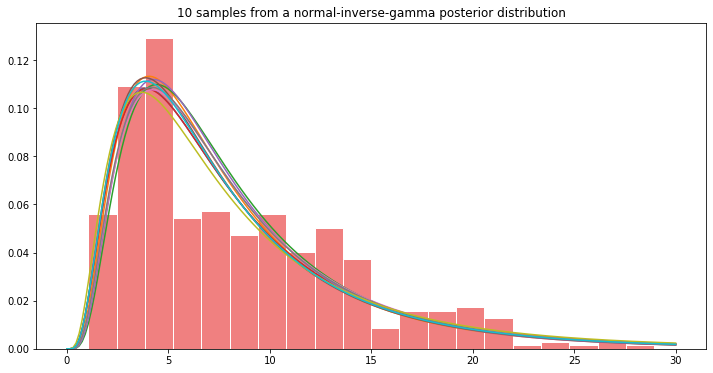

In [20]:
# Extracting samples
samples_log = results_log.extract()

# Calculating 95% posterior confidence intervals over mu and sigma2
confint_mu = np.percentile(samples_log['mu'], [2.5, 97.5])
print('Posterior 95% confidence interval over 𝜇:', confint_mu)
confint_sigma2 = np.percentile(samples_log['sigma2'], [2.5, 97.5])
print('Posterior 95% confidence interval over σ²:', confint_sigma2)

# Taking 10 samples from the posterior over mu and sigma2
num_sample = 10
sample_mu = np.random.choice(samples_log['mu'],num_sample)
sample_sigma2 = np.random.choice(samples_log['sigma2'],num_sample)

# Plotting the log-normal distributions corresponding to the 10 samples
plt.figure(figsize=(12,6))
plt.hist(hrtem, bins=20, density=True, color='lightcoral',ec='white')
plot_x = np.linspace(0, 30, 200)
for i in range(num_sample):
    plot_y = sts.lognorm.pdf(plot_x, s= np.sqrt(sample_sigma2[i]), scale=np.exp(sample_mu[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.show()

